In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import pytorch_lightning as pl

/home/user/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:


class Generator(nn.Module):
  '''
  Generator class. Accepts a tensor of size 100 as input as outputs another
  tensor of size 784. Objective is to generate an output tensor that is
  indistinguishable from the real MNIST digits 
  '''
  
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_features=100, out_features=256),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=256, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=1024),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=1024, out_features=28*28),
                                nn.Tanh())

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x


class Discriminator(nn.Module):
  '''
  Discriminator class. Accepts a tensor of size 784 as input and outputs
  a tensor of size 1, with the predicted class probabilities
  (generated or real data)
  '''

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_features=28*28, out_features=1024),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=1024, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=256),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=256, out_features=1),
                                nn.Sigmoid())
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x




In [3]:

class GAN(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.generator = Generator()
    self.discriminator = Discriminator()
    self.test_noises = torch.randn(100,1,100, device=device)
    self.test_progression = []

  def forward(self, z):
    """
    Generates an image using the generator
    given input noise z
    """
    return self.generator(z)

  def generator_step(self, x):
    """
    Training step for generator
    1. Sample random noise
    2. Pass noise to generator to
       generate images
    3. Classify generated images using
       the discriminator
    4. Backprop loss
    """
    
    # Sample noise
    # z = torch.randn(x.shape, device=device)
    z = torch.randn(x.shape[0], 1, 100, device=device)

    # Generate images
    generated_imgs = self(z)

    # Classify generated images
    # using the discriminator
    d_output = torch.squeeze(self.discriminator(generated_imgs))

    # Backprop loss
    g_loss = nn.BCELoss()(d_output, torch.ones(x.shape[0], device=device))

    return g_loss

  def discriminator_step(self, x):
    """
    Training step for discriminator
    1. Get actual images
    2. Get fake images from generator
    3. Predict probabilities of actual images
    4. Predict probabilities of fake images
    5. Get loss of both and backprop
    """
    
    # Real images
    d_output = torch.squeeze(self.discriminator(x))
    loss_real = nn.BCELoss()(d_output, torch.ones(x.shape[0], device=device))

    # Fake images
    z = torch.randn(x.shape[0], 1, 100, device=device)
    generated_imgs = self(z)
    d_output = torch.squeeze(self.discriminator(generated_imgs))
    loss_fake = nn.BCELoss()(d_output, torch.zeros(x.shape[0], device=device))

    return loss_real + loss_fake

  def training_step(self, batch, batch_idx, optimizer_idx):
    X, _ = batch

    # train generator
    if optimizer_idx == 0:
      loss = self.generator_step(X)
    
    # train discriminator
    if optimizer_idx == 1:
      loss = self.discriminator_step(X)

    return loss

  def configure_optimizers(self):
    g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
    return [g_optimizer, d_optimizer], []

  def training_epoch_end(self, training_step_outputs):
    epoch_test_images = self(self.test_noises)
    self.test_progression.append(epoch_test_images)


In [4]:



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = torchvision.datasets.MNIST(root='../data/MNIST', download=True,
                                  transform=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5]),
                                    transforms.Lambda(lambda x: x.view(-1, 784))]))
mnist_dataloader = DataLoader(data, batch_size=128, shuffle=True, num_workers=0)
model = GAN()
trainer = pl.Trainer(max_epochs=100, gpus=1 if torch.cuda.is_available() else 0)
#trainer = pl.Trainer(max_epochs=100, gpus=1 if torch.cuda.is_available() else 0, progress_bar_refresh_rate=50)
trainer.fit(model, mnist_dataloader)

/home/user/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
/home/user/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.se

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


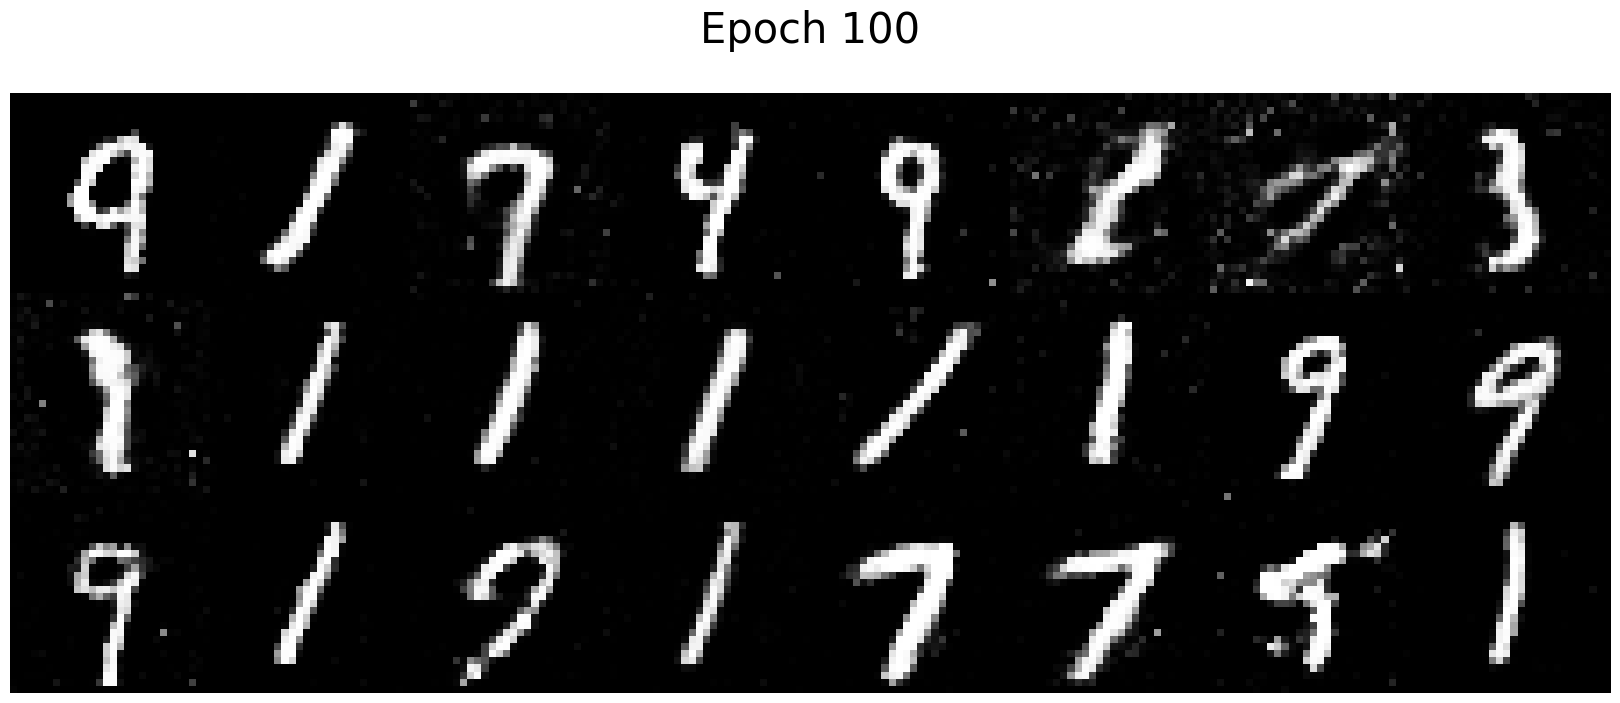

In [5]:
import numpy as np
from matplotlib import pyplot as plt, gridspec

# Convert images from torch tensor to numpy array
images = [i.detach().cpu().numpy() for i in model.test_progression]

epoch_to_plot = 100
nrow = 3
ncol = 8

# randomly select 10 images for plotting
indexes = np.random.choice(range(100), nrow*ncol, replace=False)

fig = plt.figure(figsize=((ncol+1)*2, (nrow+1)*2)) 
fig.suptitle('Epoch {}'.format(epoch_to_plot), fontsize=30)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in range(nrow):
    for j in range(ncol):
        idx = i*ncol + j
        img = np.reshape(images[epoch_to_plot-1][indexes[idx]], (28,28))
        ax = plt.subplot(gs[i,j])
        ax.imshow(img, cmap='gray')
        ax.axis('off')
